In [ ]:
!pip install hdbscan
!pip install umap-learn

     |████████████████████████████████| 6.4MB 3.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311624 sha256=cbe727597b0553529fd38f055ec280ce2c8a6220f14732cd24507e21101298a1
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
     |████████████████████████████████| 81kB 2.9MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=ea47d78b9a35ae1fe3c5623d2127cec1071f2b5cf010df17cfcde152414d4288
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=caf8836d235ef4625f3f1600b918195ba1d469efff9cf55f

In [ ]:
import re
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.manifold as manifold

import hdbscan
# from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KDTree
from pynndescent import NNDescent

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
output_notebook()

In [ ]:
!gdown --id 12TxqTPUjYrgsMAoIovRegsotmWKzigth #IMDBMovies.csv
# !gdown --id 1--_1YwPpUqMu6-V9_o3gQWopjmk0PW8j #KaggleMovies.csv

Downloading...
From: https://drive.google.com/uc?id=12TxqTPUjYrgsMAoIovRegsotmWKzigth
To: /content/IMDBMovies.csv
13.0MB [00:00, 49.0MB/s]


#### Read in the datasets

In [ ]:
df = pd.read_csv("/content/IMDBMovies.csv")
# df = pd.read_csv("/content/KaggleMovies.csv")

In [ ]:
df.head()

,tconst,titleType,startYear,genres,originalTitle,averageRating,numVotes,crewNum,title,titleID
0,630,544,1908,485,603,3.2,11,768415,hamlet,tt0000630
1,679,544,1908,1712,2800,5.2,34,4951455,the fairylogue and radio-plays,tt0000679
2,886,544,1910,485,2271,5.0,23,710351,"hamlet, prince of denmark",tt0000886
3,1285,544,1909,2116,3319,5.3,28,3686464,forty years in the land of the midian,tt0001285
4,1498,544,1911,298,2118,7.7,6,4114934,the battle of trafalgar,tt0001498


In [ ]:
df.shape

(183578, 10)

#### Normalize the data

In [ ]:
ss = MinMaxScaler()
df2 = ss.fit_transform(df[['titleType',	'startYear',	'genres',	'originalTitle', 'averageRating',	'numVotes',	'crewNum']])

## KNN

#### Find true nearest neighbours to compare against the much faster NNDescent

In [ ]:
 %%time
 treeIndex = KDTree(df2, leaf_size=2)

CPU times: user 15.6 s, sys: 113 ms, total: 15.7 s
Wall time: 15.8 s


In [ ]:
%%time
neighbours = treeIndex.query(df2, k=11)[1]

CPU times: user 22.3 s, sys: 25.1 ms, total: 22.3 s
Wall time: 22.4 s


In [ ]:
neighbours

array([[     0,    205,  50385, ...,   3893,  53353,   3725],
       [     1,    792,     96, ...,    267,   3312,  55628],
       [     2,    264,  83837, ..., 116498,  56378,  55609],
       ...,
       [183575, 142170, 179934, ..., 142487, 160697, 181756],
       [183576, 177530,  93797, ..., 163132, 152076, 183321],
       [183577, 171760,  63372, ...,  73636, 108838,  87779]])

#### Fit the data and find the k nearest neighbours

In [ ]:
%%time
index = NNDescent(df2,  n_neighbors=15, diversify_prob=0.0)
index.prepare()

CPU times: user 34.1 s, sys: 383 ms, total: 34.5 s
Wall time: 20.9 s


In [ ]:
%%time
top10near = index.query(df2, k=11, epsilon=0.2)[0]
top10near = index.query(df2, k=11)[0]
top10near

CPU times: user 3.63 s, sys: 34.9 ms, total: 3.66 s
Wall time: 3.67 s


In [ ]:
def NNDesaccuracy(top10near, neighbours):
    result = np.zeros(top10near.shape[0])
    for i in range(top10near.shape[0]):
        n_correct = np.intersect1d(top10near[i], neighbours[i]).shape[0]
        result[i] = n_correct / neighbours.shape[1]
    return result

In [ ]:
accuracy_stats = NNDesaccuracy(top10near, neighbors)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Average accuracy of 0.999905415483535


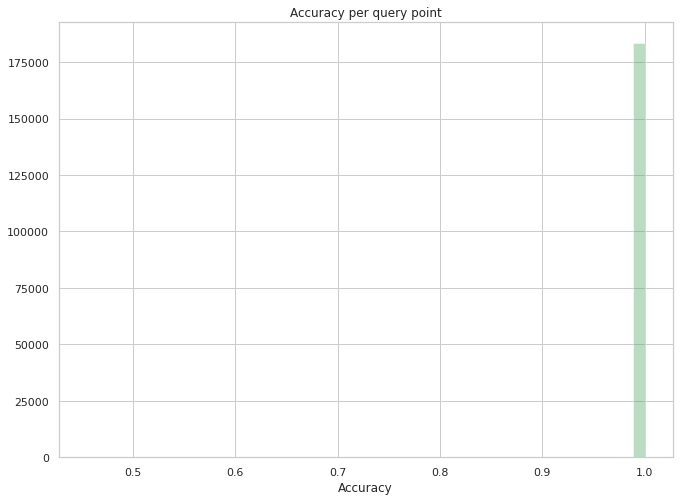

In [ ]:
plt.figure(figsize=(11,8))
sns.set_style('whitegrid')
ax = sns.distplot(accuracy_stats, kde=False, color="g") 
ax.set_title("Accuracy per query point")
ax.set_xlabel("Accuracy")
    
print(f"Average accuracy of {np.mean(accuracy_stats)}")

#### Find the 10 recommendations for a movie entered by a user (Internal Testing)

In [ ]:
def getNearest(value):
  a = np.where(df['title'].values == value.lower())
  return  df.iloc[neighbours[a[0][0]][1:]].title

In [ ]:
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: mad max


36990           tron
34634       superman
35859    superman ii
37568       wargames
37728           dune
37788       gremlins
33288    logan's run
40090     spaceballs
35803       scanners
37558     videodrome
Name: title, dtype: object

#### Output the recommendations to csv (Optional), uncomment code if needed

In [ ]:
def myfunc(row):
    return df.iloc[row].title

myfunc_vec = np.vectorize(myfunc)
top10nearTitles = myfunc_vec(top10near)
top10nearTitles

In [ ]:
movieRec = pd.DataFrame(top10nearTitles)
movieRec = movieRec.rename(columns={0: 'Movie', 1: 'Rec1', 2: 'Rec2', 3: 'Rec3', 4: 'Rec4', 5: 'Rec5', 6: 'Rec6', 7: 'Rec7', 8: 'Rec8', 9: 'Rec9', 10: 'Rec10'})
movieRec.head()

,Movie,Rec1,Rec2,Rec3,Rec4,Rec5,Rec6,Rec7,Rec8,Rec9,Rec10
0,hamlet,the house next door,irish eyes,the rail rider,the bible,the slave mart,the girl in number 29,the evil women do,the prince of avenue a,her bleeding heart,help wanted - male
1,the fairylogue and radio-plays,the new exploits of elaine,the adventures of andy,the ghost breaker,the fighting gringo,who will marry mary?,the hand of vengeance,gretchen blunders in,the million dollar mystery,perils of thunder mountain,the new adventures of j. rufus wallingford
2,"hamlet, prince of denmark",the merchant of venice,beverly of graustark,michael strogoff,shadows of the moulin rouge,mormon's offer,the naked truth,the fall of a nation,victory or death,lucretia borgia,the last of the ingrahams
3,forty years in the land of the midian,the strange story of sylvia gray,a romance of the redwoods,nan of music mountain,carmen of the klondike,antony and cleopatra,princess romanoff,the last egyptian,the woman in the web,the millionaire baby,the master key
4,the battle of trafalgar,the man who could not lose,the land of the lost,the dawn of a tomorrow,the innocence of ruth,the man from home,the valley of the moon,after the ball,the cossack whip,polly of the circus,the wall invisible


In [ ]:
def getNearest(value):
  a = np.where(df['title'].values == value.lower())
  return  df.iloc[neighbours[a[0][0]][1:]].title

In [ ]:
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: mad max


36990           tron
34634       superman
35859    superman ii
37568       wargames
37728           dune
37788       gremlins
33288    logan's run
40090     spaceballs
35803       scanners
37558     videodrome
Name: title, dtype: object

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
movieRec.to_csv('/content/drive/My Drive/Big Data Project/data/MovieRecs.csv', index=False)

## KNN PCA

In [ ]:
pca = PCA(n_components=2)
df3 = pca.fit_transform(df2)

In [ ]:
df3

array([[-0.18607159, -0.15005497],
       [-0.25832495,  0.13157282],
       [-0.21378876,  0.02009367],
       ...,
       [-0.16155042, -0.0251919 ],
       [-0.20470835,  0.22335895],
       [ 0.88971501, -0.26487263]])

In [ ]:
index2 = NNDescent(df3)

In [ ]:
top10near2 = index2.query(df3, k=11)[0]
top10near2

array([[     0,  19402,   6383, ...,  50958,   8288,    935],
       [     1,   1984,   6502, ...,   8101,  68682,   6336],
       [     2,  51450,  11211, ...,  16393,   2748,  60984],
       ...,
       [183575,  52361,  48711, ...,  38741, 129421,  44465],
       [183576, 159743, 109955, ..., 104189,  69466,  71640],
       [183577, 183101, 157897, ..., 176922,  90359, 149901]], dtype=int32)

In [ ]:
def getNearest(value):
  a = np.where(df['title'].values == value.lower())
  return  df.iloc[top10near2[a[0][0]]].title

In [ ]:
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: mad max


35049                                   mad max
27261                           fields of honor
32408                      the towering inferno
32155                      lancelot of the lake
34182                             capricorn one
35562                                   paydirt
32980        john milius' the wind and the lion
18880                         germany year zero
38706    starchaser: the legend of orin- in 3-d
33335                            violent naples
Name: title, dtype: object

## KNN UMAP

In [ ]:
df4 = umap.UMAP(n_components=2).fit_transform(df2)

In [ ]:
df4

array([[ 8.088617 , 18.117037 ],
       [ 9.414087 , 16.516026 ],
       [ 7.082261 , 18.742085 ],
       ...,
       [ 6.2989755, -1.749881 ],
       [ 3.9141693, -1.4279182],
       [-7.51618  , 10.790727 ]], dtype=float32)

In [ ]:
index3 = NNDescent(df4, n_neighbors=50,
    diversify_prob=0.0,
    pruning_degree_multiplier=3.0)

In [ ]:
top10near3 = index3.query(df4, k=11, epsilon=0.5)[0]
top10near3

array([[     0,   3893,   5319, ...,  61967,   3684,   3725],
       [     1,    605,   2519, ...,   3942,    705,   3957],
       [     2,  69892,  56378, ...,  83837,    531,   1401],
       ...,
       [183575, 162685, 165299, ..., 142459, 129421, 143981],
       [183576, 169579, 151786, ..., 171898, 152970, 132069],
       [183577, 130203,  97553, ...,  71186,  89389,  76681]], dtype=int32)

In [ ]:
def getNearest(value):
  a = np.where(df['title'].values == value.lower())
  return  df.iloc[top10near3[a[0][0]]].title

In [ ]:
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: toy story


47024                                      toy story
67943                                       p.o.t.c.
79556                  avatar: an imax 3d experience
63532                                   finding nemo
45599                                  the lion king
83714                                         wall-e
46231                                     braveheart
70747                                        ironman
54677                                the sixth sense
37413    star wars: episode vi - revenge of the jedi
88232                                             up
Name: title, dtype: object